In [1]:
using DifferentialEquations
using ShiftedArrays
using Plots
using Statistics
using CUDA

using RecursiveArrayTools # this is cool but manage to make it work only in place and in place seems broken for SDE.



In [77]:
lambda = 4.0
m2 = -4.8129999999999997
H = 0.01
N=32
dt=0.01
tMax = 10.0



#u0=CUDA.zeros(4,N,N,N)
#phi2=CUDA.zeros(N,N,N)

u0 = zeros(4,N,N,N)
phi2 = zeros(N,N,N)


du=similar(u0)



lapl3D(u) = circshift(u,(0,1,0,0)) .+ circshift(u,(0,-1,0,0)) .+ circshift(u,(0,0,-1,0)) .+ circshift(u,(0,0,1,0)) .+ circshift(u,(0,0,0,1)) .+ circshift(u,(0,0,0,-1)) .- 6.0.*u
#lapl3D(u) = ShiftedArrays.circshift(u,(1,0,0)) .+ ShiftedArrays.circshift(u,(-1,0,0)) .+ ShiftedArrays.circshift(u,(0,-1,0)) .+ ShiftedArrays.circshift(u,(0,1,0)) .+ ShiftedArrays.circshift(u,(0,0,1)) .+ ShiftedArrays.circshift(u,(0,0,-1)) .- 6.0.*u

g(u, p, t) = sqrt(2)

function full_f(u,p,t, du, phi2, lambda, m2, H)
    phi2 .= 0
    for i in 1:4
        mu = @view u[i,:,:,:]
        phi2.+=mu.^2
    end
    du .= lapl3D(u)
    for i in 1:4
        mu = @view u[i,:,:,:]
        mdu = @view du[i,:,:,:]
        
        mdu .-=(lambda.* phi2 .+m2).* mu  .- (i==1 ? H : 0)
    end
    return du
end
 
f = (u,p,t) -> full_f(u,p,t, du, phi2, lambda, m2, H) 
prob = SDEProblem(f,g,u0, (0.0, tMax));

In [79]:
@time f(u0,undef,1.0);

  0.008618 seconds (186 allocations: 7.008 MiB)


In [82]:
@time sol = solve(prob,EM(),dt=dt,save_everystep=true);

  4.815588 seconds (216.22 k allocations: 15.644 GiB, 13.81% gc time)


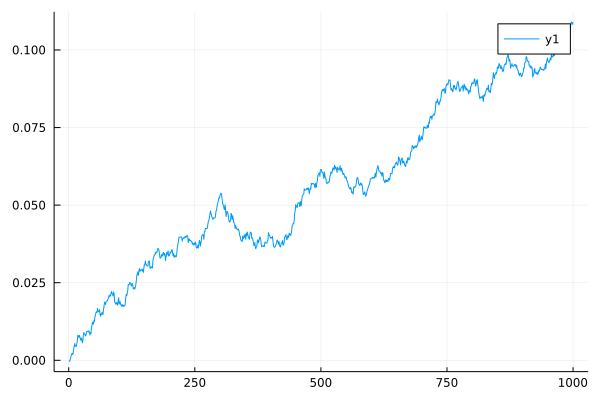

In [83]:
plot(map(i->mean(sol[1,:,:,:,i]),1:1000))

In [5]:
mapreduce(x->x,+,u0,dims=(1))

1×32×32×32 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

...

[:, :, 30, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 31, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 32, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 1, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

...

[:, :, 30, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 31, 2] =


In [18]:

#v1
lambda = 4.0
m2 = -4.8129999999999997
H = 0.01
N=32

phi2=zeros(N,N,N)
du=zeros(4,N,N,N)



lapl3D(u) = ShiftedArrays.circshift(u,(1,0,0)) .+ ShiftedArrays.circshift(u,(-1,0,0)) .+ ShiftedArrays.circshift(u,(0,-1,0)) .+ ShiftedArrays.circshift(u,(0,1,0)) .+ ShiftedArrays.circshift(u,(0,0,1)) .+ ShiftedArrays.circshift(u,(0,0,-1)) .- 6.0.*u
g(u, p, t) = sqrt(2)
function gf(u,p,t)
    #phi2 .= reduce(+, mapslices(x->x.^2,u, dims=(2,3,4)), dims=1)[1,:,:,:] 
    phi2 .= u[1,:,:,:].^2 .+u[2,:,:,:].^2 .+u[3,:,:,:].^2 .+u[4,:,:,:].^2
    for i in 1:4
        du[i,:,:,:] .= lapl3D(u[i,:,:,:]) .- (lambda .* phi2 .+ m2).* u[i,:,:,:] .+ (i==1 ? H : 0)
    end
    return du
end
 

dt=0.01

u0=zeros(4,N,N,N)


prob = SDEProblem(gf,g,u0, (0.0, 10.0));

In [15]:
#also tried with in placed laplacian, does not change in the end.

function lapl3D!(du, u, shiftu)  
        du.-=6.0.*u
        circshift!(shiftu,u,(1,0,0)) 
        du.+=shiftu
        circshift!(shiftu,u,(-1,0,0)) 
        du .+= shiftu
        circshift!(shiftu,u,(0,1,0)) 
        du .+= shiftu
        circshift!(shiftu,u,(0,-1,0)) 
        du .+= shiftu
        circshift!(shiftu,u,(0,0,1)) 
        du .+= shiftu
        circshift!(shiftu,u,(0,0,-1)) 
        du .+= shiftu
end


lapl3D! (generic function with 1 method)

INPLACE_WHITE_NOISE_DIST (generic function with 1 method)